In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(1)

Training Data X : (4096, 401)
Training Data Y : (1, 401)
Test Data X : (4096, 9)
Trest Data Y : (1, 9)
Test image shows a : 0


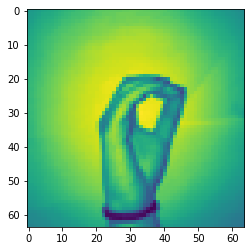

In [28]:
X = np.load('C:/Users/Rushad/Desktop/handsign-recog/data/X.npy')
Y = np.load('C:/Users/Rushad/Desktop/handsign-recog/data/Y.npy')

x = np.concatenate((X[204:409], X[822:1027] ), axis=0)
y = np.concatenate((np.zeros(205), np.ones(205)), axis=0).reshape(x.shape[0],1)

train_pct_index = int(0.98 * len(x))
x_train, x_test = x[:train_pct_index], x[train_pct_index:]
y_train, y_test = y[:train_pct_index].T, y[train_pct_index:].T

train_Xflat = x_train.reshape(-1, x_train.shape[0])
test_Xflat = x_test.reshape(-1, x_test.shape[0])

print("Training Data X : " + str(train_Xflat.shape))
print("Training Data Y : " + str(y_train.shape))
print("Test Data X : " + str(test_Xflat.shape))
print("Trest Data Y : " + str(y_test.shape))

plt.imshow(x_train[120])
print("Test image shows a : " + str(round(float(y_train[0][120]))))

In [24]:
def initialize_parameters(layerdims):
    '''layerdims: List containing no. of units in each layer
    '''
    parameters={}
    L = len(layerdims)
    for i in range(1, L):
        parameters["W"+str(i)] = np.random.randn( layerdims[i], layerdims[i-1]) * np.sqrt(2/(layerdims[i-1] + layer_dims[i]))
        parameters["b"+str(i)] = np.zeros( (layerdims[i],1))
        
    return parameters

In [4]:
def forward(A_prev, W, b, activation):
    ''' Forward Propagation for Single layer
    '''
    # Linear 
    Z = np.add( np.dot(W,A_prev), b)
    
    # Activation Function 
    if activation== "sigmoid":
        A=1/(1+np.exp(-Z))
        
    if activation== "relu":
        A = np.maximum(0,Z)
        
    cache=(A_prev,W,b,Z)
    
    return A, cache

In [5]:
def L_layer_forward(X, parameters, layerdims):
    ''' Forward propagation for L-layer
    '''
    caches=[]
    L =  len(layerdims)-1
    A = X
    
    
    # L[0] is units for Input layer
    # [LINEAR -> RELU]*(L-1)    Forward for L-1 layers 
    for l in range(1,L):
        A_prev = A
        A, cache=forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], "relu")
        caches.append(cache)
      
    # Forward for Last layer
    # [Linear -> sigmoid]
    y_hat, cache=forward(A, parameters["W"+str(l+1)], parameters["b"+str(l+1)], "sigmoid")
    caches.append(cache)
    
    return y_hat, caches

In [6]:
def compute_cost(y_hat, Y):
    '''Computes the Loss
    '''
    m = Y.shape[1]
    costt = np.add(  np.multiply(Y, np.log(y_hat)) ,  np.multiply(1-Y, np.log(1-y_hat))  ) 
    cost = (-1/m) * np.sum(costt, axis=1)
    
    return cost

In [7]:
def backward(dA,  cache, activation):
    '''Backward propagation for single layer
    '''
    A_prev,W,b,Z = cache
    m= A_prev.shape[1]
    
    # Computing derivative of Cost wrt Z
    
    # dA, Z, 
    if activation == "relu":
        dZ = np.array(dA, copy=True)
        dZ[Z <=0] =0
        
    if activation == "sigmoid":
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)
        
    
    # Computing derivative of Cost wrt A & W  & b
    dA_prev = np.dot(W.transpose(), dZ)
    dW = (1/m) * np.dot(dZ, A_prev.transpose())
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
   
    
    return dA_prev, dW, db

In [8]:
def L_layer_backward(y_hat, Y, caches, layerdims):
    ''' Backward Propogation from layer L to 1
    '''
    AL = y_hat 
    L = len(layerdims) -1
    grads={}
    
    # Intializing Backpropagation
    
    # Compute derivation of Cost wrt A
    dAL = -(np.divide(Y,AL) - np.divide(1-Y, 1-AL))
    
    
    # Compute derivative of Lth layer (Sigmoid -> Linear) gradients. 
    # Inputs: (AL, Y, caches)     Outputs: (grad["dAL"], grad["dWL] , grad["dbL"])
    grads["dA"+str(L)], grads["dW"+str(L)], grads["db"+str(L)] = backward(dAL, caches[-1], activation="sigmoid")
    
   
    # Compute derivative for (1,2,..L-1)layers (relu -> Linear) gradients.
    # Inputs:(grads[dAL], caches)   Outputs:(grads(dA_i, dW_i, db_i) )
    
   
    for i in list(reversed(range(L-1))):                       
        
        current_cache = caches[i]
        
        a,b,c=backward(grads["dA"+str(i+2)], current_cache, activation="relu")
        grads["dA"+str(i+1)] = a
        grads["dW"+str(i+1)] = b
        grads["db"+str(i+1)] = c
        
    return grads

In [9]:
def update_params(params, grads, learning_rate):
    '''
        Parameter update using Gradient descent
    '''
    # As each layer has 2 parameters (W,b)
    L=len(params) // 2
    
    for l in range(L):
        params["W"+str(l+1)] = params["W"+str(l+1)] - learning_rate * grads["dW"+str(l+1)]
        params["b"+str(l+1)] = params["b"+str(l+1)] - learning_rate * grads["db"+str(l+1)]
        
    return params

In [10]:
def nn_model_train(X, Y, layer_dims, learning_rate, num_itr, parameters, initialize=False):
    ''' Implements a L-layer NN: .
    '''
    costs=[]
    
    if initialize:
        parameters = initialize_parameters(layer_dims)
    
   
    # Gradient Descent
    for i in range(num_itr):
        
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID
        y_hat, caches = L_layer_forward(X, parameters, layer_dims)

        # Compute Cost
        cost = compute_cost(y_hat, Y)

        # Backward propagation
        grads = L_layer_backward(y_hat, Y, caches, layer_dims)

        # Update Parameters
        parameters = update_params(parameters, grads, learning_rate)
        
        if i%200 ==0:
            print(f"cost {i}: {np.squeeze(cost)}")
        if i%100 ==0:
            costs.append(cost[0])

    # Ploting the Cost
    plt.plot(costs)
    plt.xlabel("n iteration")
    plt.ylabel("cost")
    
    return parameters

In [16]:
def predict(X,Y, parameters):
    '''
    Predict probablity (y) of given input X
    '''
    m= X.shape[1]
    # forward propagation
    y_hat, caches = L_layer_forward(X, parameters, layer_dims)
    
    y_hat=y_hat.reshape(-1)
    predicted=np.where(y_hat>0.5, 1, 0)
    
    accuracy = np.sum(predicted == Y) / m
     
    return(accuracy, predicted)

cost 0: 0.6907376933023002
cost 200: 0.662562810745836
cost 400: 0.5972308720084204
cost 600: 0.45710145165433386
cost 800: 0.43314705795595443
cost 1000: 0.3108770772695437
cost 1200: 0.16762621393625693
cost 1400: 0.05916323087413984
cost 1600: 0.037130718363685374
cost 1800: 0.02569083483974984
cost 2000: 0.018936540801473393
cost 2200: 0.01460923870007285
cost 2400: 0.011668524340719954
cost 2600: 0.009576093401573239
cost 2800: 0.008031826340641266


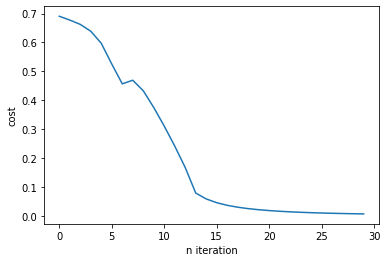

In [29]:
layer_dims = [4096, 20, 7, 5, 1]
parameters = initialize_parameters(layer_dims)
parameters = nn_model_train(train_Xflat, y_train, layer_dims, 0.005, 3000, parameters, initialize=False)

In [30]:
#cache the parameters in parameters.pkl file and load them back from the file
import pickle
pickle.dump(parameters, open('parameters.pkl', 'wb'))
parameters = pickle.load(open("parameters.pkl", 'rb'))

In [31]:
train_accuracy, train_predictedValues = predict(train_Xflat, y_train, parameters)
test_accuracy, test_predictedValues = predict(test_Xflat, y_test, parameters)

print("Train Data Accuracy:" + str(train_accuracy))
print("Test Accuracy:" + str(test_accuracy))

Train Data Accuracy:1.0
Test Accuracy:0.4444444444444444
